In [5]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np

from strategy_agent import StrategyAgent
from risk_agent import RiskAgent
from allocator_agent import AllocatorAgent
data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)


ReflectionAgent takes RiskAgent’s notes.

It interprets them in natural language.

It proposes parameter changes (structured as a dict).

In [6]:
class ReflectionAgent:
    def __init__(self):
        pass
    
    def reflect(self, assessment: dict):
        """
        Takes a RiskAgent assessment {Decision, Notes}
        Returns: reasoning (text) and new_params (dict)
        """
        notes = assessment["Notes"]
        reasoning = []
        new_params = {}
        
        for note in notes:
            if "Sharpe too low" in note:
                reasoning.append("Sharpe ratio too low → increase slow SMA window for more stability.")
                new_params["sma_slow"] = 100  # longer horizon
            if "Volatility too high" in note:
                reasoning.append("Volatility too high → widen RSI thresholds to reduce over-trading.")
                new_params["rsi_lower"] = 25
                new_params["rsi_upper"] = 75
            if "Drawdown too high" in note:
                reasoning.append("Drawdown exceeded limit → shift Allocator to equal-weight instead of Sharpe-weight.")
                new_params["allocation"] = "equal"
        
        if not reasoning:
            reasoning.append("All good — no changes needed.")
        
        return {"Reasoning": reasoning, "New_Params": new_params}


In [7]:
def reflective_loop(data, max_attempts=3):
    attempt = 0
    decision = "FAIL"
    portfolio = None
    reflection_log = []
    
    # Default params
    sma_fast, sma_slow = 10, 50
    rsi_lower, rsi_upper = 30, 70
    alloc_method = "sharpe"
    
    while attempt < max_attempts and decision == "FAIL":
        attempt += 1
        print(f"\nAttempt {attempt} -----------------")
        
        # Strategy Agent
        sa = StrategyAgent(data)
        strategies = {
            f"SMA": sa.sma_crossover(fast=sma_fast, slow=sma_slow),
            f"RSI": sa.rsi_strategy(lower=rsi_lower, upper=rsi_upper),
            f"BB": sa.bollinger_breakout()
        }
        
        # Metrics
        def compute_metrics(df):
            if "Strategy_Return" in df.columns:
                returns = df["Strategy_Return"]
            elif "Portfolio_Return" in df.columns:
                returns = df["Portfolio_Return"]
            else:
                raise KeyError("No valid return column found")
            strat_curve = (1 + returns.fillna(0)).cumprod()
            years = (returns.index[-1] - returns.index[0]).days / 365.25
            cagr = strat_curve.iloc[-1]**(1/years) - 1 if years > 0 else 0
            vol = returns.std() * np.sqrt(252)
            sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
            roll_max = strat_curve.cummax()
            dd = (strat_curve / roll_max - 1).min()
            return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}
        
        metrics = {name: compute_metrics(df) for name, df in strategies.items()}
        
        # Risk Agent
        ra = RiskAgent(sharpe_min=1.0, max_dd=-0.25, vol_max=0.3)
        risk_assessments = {name: ra.assess(m) for name, m in metrics.items()}
        
        # Allocator
        alloc = AllocatorAgent(method=alloc_method)
        weights, portfolio = alloc.allocate(strategies, metrics, risk_assessments)
        if portfolio is None:
            print("No strategies passed risk checks.")
            continue
        
        # Portfolio-level risk
        portfolio_metrics = compute_metrics(portfolio)
        portfolio_assessment = ra.assess(portfolio_metrics)
        print("Portfolio metrics:", portfolio_metrics)
        print("Assessment:", portfolio_assessment)
        
        decision = portfolio_assessment["Decision"]
        
        # ReflectionAgent if FAIL
        if decision == "FAIL":
            ref = ReflectionAgent()
            feedback = ref.reflect(portfolio_assessment)
            reflection_log.append(feedback)
            print("Reflection:", feedback)
            
            # Apply suggested parameter changes
            if "sma_slow" in feedback["New_Params"]:
                sma_slow = feedback["New_Params"]["sma_slow"]
            if "rsi_lower" in feedback["New_Params"]:
                rsi_lower = feedback["New_Params"]["rsi_lower"]
            if "rsi_upper" in feedback["New_Params"]:
                rsi_upper = feedback["New_Params"]["rsi_upper"]
            if "allocation" in feedback["New_Params"]:
                alloc_method = feedback["New_Params"]["allocation"]
    
    return portfolio, decision, reflection_log



Attempt 1 -----------------
Portfolio metrics: {'CAGR': np.float64(0.13984910882294188), 'Volatility': np.float64(0.04382244081992633), 'Sharpe': np.float64(2.9944674019850326), 'MaxDD': np.float64(-0.007035576834644064)}
Assessment: {'Decision': 'PASS', 'Notes': ['All risk checks passed']}

Final Decision: PASS
Reflections log:


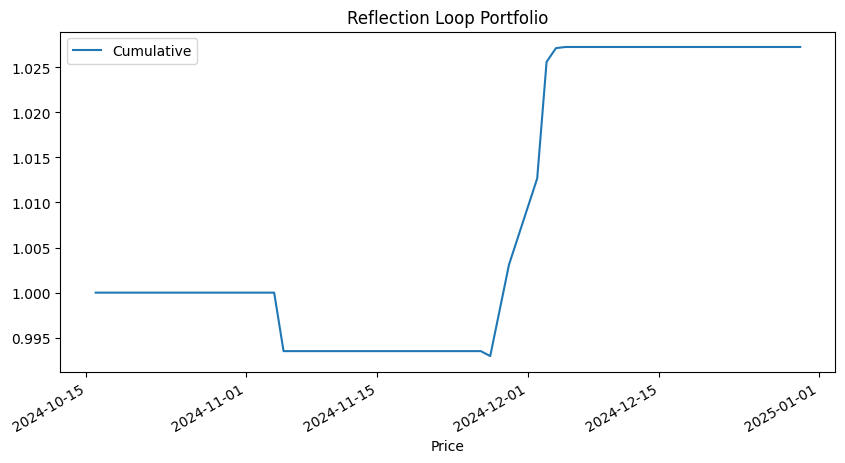

In [8]:
portfolio, decision, reflections = reflective_loop(data)

print("\nFinal Decision:", decision)
print("Reflections log:")
for r in reflections:
    print(r)
    
if portfolio is not None:
    portfolio[["Cumulative"]].plot(title="Reflection Loop Portfolio", figsize=(10,5))


In [9]:
import os
from datetime import datetime

os.makedirs("../logs", exist_ok=True)

if portfolio is not None:
    portfolio.to_csv("../logs/Day16_reflective_portfolio.csv")

with open("../logs/Day16_summary.txt", "w") as f:
    f.write(f"Day 16 run ({datetime.today().date()})\n")
    f.write(f"Decision: {decision}\n")
    f.write("Reflections:\n")
    for r in reflections:
        f.write(str(r) + "\n")


In [11]:
with open("../src/reflection_agent.py", "w", encoding="utf-8") as f:
    f.write("""class ReflectionAgent:
    def __init__(self):
        pass
    
    def reflect(self, assessment: dict):
        notes = assessment["Notes"]
        reasoning = []
        new_params = {}
        
        for note in notes:
            if "Sharpe too low" in note:
                reasoning.append("Sharpe ratio too low -> increase slow SMA window for more stability.")
                new_params["sma_slow"] = 100
            if "Volatility too high" in note:
                reasoning.append("Volatility too high -> widen RSI thresholds to reduce over-trading.")
                new_params["rsi_lower"] = 25
                new_params["rsi_upper"] = 75
            if "Drawdown too high" in note:
                reasoning.append("Drawdown exceeded limit -> shift Allocator to equal-weight instead of Sharpe-weight.")
                new_params["allocation"] = "equal"
        
        if not reasoning:
            reasoning.append("All good - no changes needed.")
        
        return {"Reasoning": reasoning, "New_Params": new_params}
""")
